```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`The Income Fluctuation Problem I: Basic Model <single: The Income Fluctuation Problem I: Basic Model>`

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

In this lecture, we study an optimal savings problem for an infinitely lived consumer---the "common ancestor" described in {cite}`Ljungqvist2012`, section 1.3.

This savings problem is often called an **income fluctuation problem** or a **household problem**.

It is an essential sub-problem for many representative macroeconomic models

* {cite}`Aiyagari1994`
* {cite}`Huggett1993`
* etc.

It is related to the decision problem in the {doc}`cake eating model <cake_eating_stochastic>` but differs in significant ways.

For example, 

1. The choice problem for the agent includes an additive income term that leads to an occasionally binding constraint.
2. Shocks affecting the budget constraint are correlated, forcing us to track an extra state variable.

To solve the model we will use the endogenous grid method, which we found to be {doc}`fast and accurate <cake_eating_egm_jax>` in our investigation of cake eating.

We'll need the following imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from quantecon import MarkovChain
import jax
import jax.numpy as jnp
from typing import NamedTuple

We will use 64-bit precision in JAX because we want to compare NumPy outputs with JAX outputs --- and NumPy arrays default to 64 bits.

In [3]:
jax.config.update("jax_enable_x64", True)

### References

The primary source for the technical details discussed below is {cite}`ma2020income`.

Other references include {cite}`Deaton1991`, {cite}`DenHaan2010`,
{cite}`Kuhn2013`, {cite}`Rabault2002`,  {cite}`Reiter2009`  and
{cite}`SchechtmanEscudero1977`.


## The Household Problem

```{index} single: Optimal Savings; Problem
```

Let's write down the model and then discuss how to solve it.

### Set-Up

Consider a household that chooses a state-contingent consumption plan $\{c_t\}_{t \geq 0}$ to maximize

$$
\mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

```{math}
:label: eqst

a_{t+1} = R (a_t - c_t) + Y_{t+1}
\quad c_t \geq 0,
\quad a_t \geq 0
\quad t = 0, 1, \ldots
```

Here

* $\beta \in (0,1)$ is the discount factor
* $a_t$ is asset holdings at time $t$, with borrowing constraint $a_t \geq 0$
* $c_t$ is consumption
* $Y_t$ is non-capital income (wages, unemployment compensation, etc.)
* $R := 1 + r$, where $r > 0$ is the interest rate on savings

The timing here is as follows:

1. At the start of period $t$, the household observes current asset holdings $a_t$.
1. The household chooses current consumption $c_t$.
1. Savings $s_t := a_t - c_t$ earns interest at rate $r$.
1. Labor income $Y_{t+1}$ is realized and time shifts to $t+1$.

Non-capital income $Y_t$ is given by $Y_t = y(Z_t)$, where

* $\{Z_t\}$ is an exogenous state process and
* $y$ is a given function taking values in $\mathbb{R}_+$.

As is common in the literature, we take $\{Z_t\}$ to be a finite state
Markov chain taking values in $\mathsf Z$ with Markov matrix $\Pi$.

```{note}
The budget constraint for the household is more often written as $a_{t+1} + c_t \leq R a_t + Y_t$.

This setup was developed for discretization. 

it means that the control is also the next period state $a_{t+1}$, which can then be restricted to a finite grid.

Computational economists are moving away from raw discretization, which allows
the use of alternative timings, such as the one that we adopt.

Our timing turns out to slightly easier in terms of minimizing state variables
(because transient components of labor income are automatially integrated out --- see
{doc}`this lecture <ifp_advanced>`) and studying dynamics.

In practice, either timing can be used when including households in larger models.

```

We further assume that

1. $\beta R < 1$
1. $u$ is smooth, strictly increasing and strictly concave with $\lim_{c \to 0} u'(c) = \infty$ and $\lim_{c \to \infty} u'(c) = 0$
1. $y(z) = \exp(z)$ 

The asset space is $\mathbb R_+$ and the state is the pair $(a,z) \in \mathsf S := \mathbb R_+ \times \mathsf Z$.

A **feasible consumption path** from $(a,z) \in \mathsf S$ is a consumption
sequence $\{c_t\}$ such that $\{c_t\}$ and its induced asset path $\{a_t\}$ satisfy

1. $(a_0, z_0) = (a, z)$
1. the feasibility constraints in {eq}`eqst`, and
1. adaptedness, which means that $c_t$ is a function of random
   outcomes up to date $t$ but not after.

The meaning of the third point is just that consumption at time $t$
cannot be a function of outcomes are yet to be observed.

In fact, for this problem, consumption can be chosen optimally by taking it to
be contingent only on the current state.

Optimality is defined below.



### Value Function and Euler Equation

The **value function** $V \colon \mathsf S \to \mathbb{R}$ is defined by

```{math}
:label: eqvfs

V(a, z) := \max \, \mathbb{E}
\left\{
\sum_{t=0}^{\infty} \beta^t u(c_t)
\right\}
```

where the maximization is overall feasible consumption paths from $(a,z)$.

An **optimal consumption path** from $(a,z)$ is a feasible consumption path from $(a,z)$ that maximizes {eq}`eqvfs`.

To pin down such paths we can use a version of the Euler equation, which in the present setting is

```{math}
:label: ee00

    u' (c_t) \geq \beta R \,  \mathbb{E}_t  u'(c_{t+1})
```

with

```{math}
:label: ee01

    c_t < a_t
    \; \implies \;
    u' (c_t) = \beta R \,  \mathbb{E}_t  u'(c_{t+1})
```

When $c_t$ hits the upper bound $a_t$, the
strict inequality $u' (c_t) > \beta R \,  \mathbb{E}_t  u'(c_{t+1})$
can occur because $c_t$ cannot increase sufficiently to attain equality.

The lower boundary case $c_t = 0$ never arises along the optimal path because $u'(0) = \infty$.


### Optimality Results

As shown in {cite}`ma2020income`,

1. For each $(a,z) \in \mathsf S$, a unique optimal consumption path from $(a,z)$ exists
1. This path is the unique feasible path from $(a,z)$ satisfying the
   Euler equations {eq}`ee00`-{eq}`ee01` and the transversality condition

```{math}
:label: eqtv

\lim_{t \to \infty} \beta^t \, \mathbb{E} \, [ u'(c_t) a_{t+1} ] = 0
```

Moreover, there exists an **optimal consumption policy**
$\sigma^* \colon \mathsf S \to \mathbb R_+$ such that the path
from $(a,z)$ generated by

$$
    (a_0, z_0) = (a, z),
    \quad
    c_t = \sigma^*(a_t, Z_t)
    \quad \text{and} \quad
    a_{t+1} = R (a_t - c_t) + Y_{t+1}
$$

satisfies both the Euler equations {eq}`ee00`-{eq}`ee01` and {eq}`eqtv`, and hence is the unique optimal
path from $(a,z)$.

Thus, to solve the optimization problem, we need to compute the policy $\sigma^*$.

(ifp_computation)=
## Computation

```{index} single: Optimal Savings; Computation
```

We solve for the optimal consumption policy using time iteration and the
endogenous grid method.

Readers unfamiliar with the endogenous grid method should review the discussion
in {doc}`cake_eating_egm`.

### Solution Method

We rewrite {eq}`ee01` to make it a statement about functions rather than
random variables:


```{math}
:label: eqeul1

    (u' \circ \sigma)  (a, z)
    = \beta R \, \sum_{z'}  (u' \circ \sigma)
            [R (a - \sigma(a, z)) + y(z'), \, z'] \Pi(z, z')
```

Here

* $(u' \circ \sigma)(s) := u'(\sigma(s))$,
* primes indicate next period states (as well as derivatives), and
* $\sigma$ is the unknown function.

The equality {eq}`eqeul1` holds at all interior choices, meaning $\sigma(a, z) < a$.

We aim to find a fixed point $\sigma$ of {eq}`eqeul1`.

To do so we use the EGM.

Below we use the relationships $a_t = c_t + s_t$ and $a_{t+1} = R s_t + y(z_{t+1})$.

We begin with an exogenous savings grid $s_0 < s_1 < \cdots < s_m$ with $s_0 = 0$.

We fix a current guess of the policy function $\sigma$.

For each exogenous savings level $s_i$ with $i \geq 1$ and current state $z_j$, we set

$$
    c_{ij} := (u')^{-1}
        \left[
            \beta R \, \sum_{z'}
            u' [ \sigma(R s_i + y(z'), z') ] \Pi(z_j, z')
        \right]
$$

The Euler equation holds here because $i \geq 1$ implies $s_i > 0$ and hence consumption is interior.

For the boundary case $s_0 = 0$ we set

$$
    c_{0j} := 0  \quad \text{for all j}
$$

We then obtain a corresponding endogenous grid of current assets via

$$
    a^e_{ij} := c_{ij} + s_i.
$$

Notice that, for each $j$, we have $a^e_{0j} = c_{0j} = 0$.

This anchors the interpolation at the correct value at the origin, since,
without borrowing, consumption is zero when assets are zero.

Our next guess of the policy function, which we write as $K\sigma$, is the linear interpolation of
the interpolation points 

$$ \{(a^e_{0j}, c_{0j}), \ldots, (a^e_{mj}, c_{mj})\} $$

for each $j$.

(The number of one-dimensional linear interpolations is equal to the size of $\mathsf Z$.)


## NumPy Implementation

In this section we'll code up a NumPy version of the code that aims only for
clarity, rather than efficiency.

Once we have it working, we'll produce a JAX version that's far more efficient
and check that we obtain the same results.

We use the CRRA utility specification

$$
    u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$

Here are the utility-related functions:

In [4]:
u_prime = lambda c, γ: c**(-γ)
u_prime_inv = lambda c, γ: c**(-1/γ)

### Set Up

Here we build a class called `IFPNumPy` that stores the model primitives.

The exogenous state process $\{Z_t\}$ defaults to a two-state Markov chain
with transition matrix $\Pi$.

In [5]:
class IFPNumPy(NamedTuple):
    R: float                  # Gross interest rate R = 1 + r
    β: float                  # Discount factor
    γ: float                  # Preference parameter
    Π: np.ndarray             # Markov matrix for exogenous shock
    z_grid: np.ndarray        # Markov state values for Z_t
    s: np.ndarray             # Exogenous savings grid


def create_ifp(r=0.01,
               β=0.96,
               γ=1.5,
               Π=((0.6, 0.4),
                  (0.05, 0.95)),
               z_grid=(-10.0, np.log(2.0)),
               savings_grid_max=16,
               savings_grid_size=50):

    s = np.linspace(0, savings_grid_max, savings_grid_size)
    Π, z_grid = np.array(Π), np.array(z_grid)
    R = 1 + r
    assert R * β < 1, "Stability condition violated."
    return IFPNumPy(R, β, γ, Π, z_grid, s)

# Set y(z) = exp(z)
y = np.exp

### Solver

Here is the operator $K$ that transforms current guess $\sigma$ into next period
guess $K\sigma$.

In practice, it takes in 

* a guess of optimal consumption values $c_{ij}$, stored as `c_vals`
* and a corresponding set of endogenous grid points $a^e_{ij}$, stored as `ae_vals`

These are converted into a consumption policy $a \mapsto \sigma(a, z_j)$ by 
linear interpolation of $(a^e_{ij}, c_{ij})$ over $i$ for each $j$.

In [6]:
def K_numpy(
        c_vals: np.ndarray,
        ae_vals: np.ndarray,
        ifp_numpy: IFPNumPy
    ) -> np.ndarray:
    """
    The Euler equation operator for the IFP model using the
    Endogenous Grid Method.

    This operator implements one iteration of the EGM algorithm to
    update the consumption policy function.

    """
    R, β, γ, Π, z_grid, s = ifp_numpy
    n_a = len(s)
    n_z = len(z_grid)

    new_c_vals = np.zeros_like(c_vals)

    for i in range(1, n_a):  # Start from 1 for positive savings levels
        for j in range(n_z):
            # Compute Σ_z' u'(σ(R s_i + y(z'), z')) Π[z_j, z']
            expectation = 0.0
            for k in range(n_z):
                # Set up the function a -> σ(a, z_k)
                σ = lambda a: np.interp(a, ae_vals[:, k], c_vals[:, k])
                next_c = σ(R * s[i] + y(z_grid[k]))
                expectation += u_prime(next_c, γ) * Π[j, k]
            # Calculate updated c_{ij} values
            new_c_vals[i, j] = u_prime_inv(β * R * expectation, γ)

    new_ae_vals = new_c_vals + s[:, None]

    return new_c_vals, new_ae_vals

To solve the model we use a simple while loop.

In [7]:
def solve_model_numpy(
        ifp_numpy: IFPNumPy,
        c_vals: np.ndarray,
        tol: float = 1e-5,
        max_iter: int = 1_000
    ) -> np.ndarray:
    """
    Solve the model using time iteration with EGM.

    """
    i = 0
    ae_vals = c_vals  # Initial condition
    error = tol + 1

    while error > tol and i < max_iter:
        new_c_vals, new_ae_vals = K_numpy(c_vals, ae_vals, ifp_numpy)
        error = np.max(np.abs(new_c_vals - c_vals))
        i = i + 1
        c_vals, ae_vals = new_c_vals, new_ae_vals

    return c_vals, ae_vals

Let's road test the EGM code.

In [8]:
ifp_numpy = create_ifp()
R, β, γ, Π, z_grid, s = ifp_numpy
initial_c_vals = s[:, None] * np.ones(len(z_grid))
c_vals, ae_vals = solve_model_numpy(ifp_numpy, initial_c_vals)

Here's a plot of the optimal consumption policy for each $z$ state

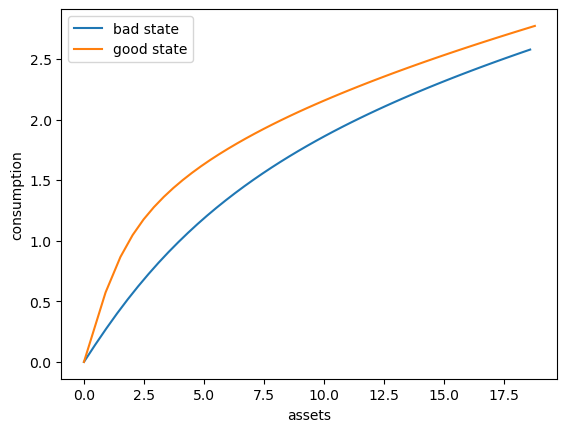

In [9]:
fig, ax = plt.subplots()

ax.plot(ae_vals[:, 0], c_vals[:, 0], label='bad state')
ax.plot(ae_vals[:, 1], c_vals[:, 1], label='good state')
ax.set(xlabel='assets', ylabel='consumption')
ax.legend()
plt.show()

## JAX Implementation

```{index} single: Optimal Savings; Programming Implementation
```

Now we write a more efficient JAX version.

### Set Up

We start with a class called `IFP` that stores the model primitives.

In [10]:
class IFP(NamedTuple):
    R: float                  # Gross interest rate R = 1 + r
    β: float                  # Discount factor
    γ: float                  # Preference parameter
    Π: jnp.ndarray            # Markov matrix for exogenous shock
    z_grid: jnp.ndarray       # Markov state values for Z_t
    s: jnp.ndarray            # Exogenous savings grid


def create_ifp(r=0.01,
               β=0.96,
               γ=1.5,
               Π=((0.6, 0.4),
                  (0.05, 0.95)),
               z_grid=(-10.0, jnp.log(2.0)),
               savings_grid_max=16,
               savings_grid_size=50):

    s = jnp.linspace(0, savings_grid_max, savings_grid_size)
    Π, z_grid = jnp.array(Π), jnp.array(z_grid)
    R = 1 + r
    assert R * β < 1, "Stability condition violated."
    return IFP(R, β, γ, Π, z_grid, s)

# Set y(z) = exp(z)
y = jnp.exp

W1124 04:18:54.387487   27158 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1124 04:18:54.391042   27094 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


### Solver

Here is the operator $K$ that transforms current guess $\sigma$ into next period
guess $K\sigma$.

In [11]:
def K(
        c_vals: jnp.ndarray, 
        ae_vals: jnp.ndarray, 
        ifp: IFP
    ) -> jnp.ndarray:
    """
    The Euler equation operator for the IFP model using the
    Endogenous Grid Method.

    This operator implements one iteration of the EGM algorithm to
    update the consumption policy function.

    """
    R, β, γ, Π, z_grid, s = ifp
    n_a = len(s)
    n_z = len(z_grid)

    # Function to compute consumption for one (i, j) pair where i >= 1
    def compute_c_ij(i, j):

        # For each k, compute u'(σ(R * s_i + y(z_k), z_k))
        def mu(k):
            next_a = R * s[i] + y(z_grid[k])
            # Interpolate to get consumption at next_a in state k
            next_c = jnp.interp(next_a, ae_vals[:, k], c_vals[:, k])
            return u_prime(next_c, γ)

        # Compute u'(σ(R * s_i + y(z_k), z_k)) at all k via vmap
        mu_vectorized = jax.vmap(mu)
        marginal_utils = mu_vectorized(jnp.arange(n_z))
        # Compute expectation: Σ_k u'(σ(...)) * Π[j, k]
        expectation = jnp.sum(marginal_utils * Π[j, :])
        # Invert to get consumption
        return u_prime_inv(β * R * expectation, γ)

    # Set up index grids for vmap computation of all c_{ij}
    i_grid = jnp.arange(1, n_a)
    j_grid = jnp.arange(n_z)

    # vmap over j for each i
    compute_c_i = jax.vmap(compute_c_ij, in_axes=(None, 0))
    # vmap over i
    compute_c = jax.vmap(lambda i: compute_c_i(i, j_grid))

    # Compute consumption for i >= 1
    new_c_interior = compute_c(i_grid)  # Shape: (n_a-1, n_z)

    # For i = 0, set consumption to 0
    new_c_boundary = jnp.zeros((1, n_z))

    # Concatenate boundary and interior
    new_c_vals = jnp.concatenate([new_c_boundary, new_c_interior], axis=0)

    # Compute endogenous asset grid: a^e_{ij} = c_{ij} + s_i
    new_ae_vals = new_c_vals + s[:, None]

    return new_c_vals, new_ae_vals

Here's a jit-accelerated iterative routine to solve the model using this operator.

In [12]:
@jax.jit
def solve_model(ifp: IFP,
                c_vals: jnp.ndarray,
                tol: float = 1e-5,
                max_iter: int = 1000) -> jnp.ndarray:
    """
    Solve the model using time iteration with EGM.

    """

    def condition(loop_state):
        c_vals, ae_vals, i, error = loop_state
        return (error > tol) & (i < max_iter)

    def body(loop_state):
        c_vals, ae_vals, i, error = loop_state
        new_c_vals, new_ae_vals = K(c_vals, ae_vals, ifp)
        error = jnp.max(jnp.abs(new_c_vals - c_vals))
        i += 1
        return new_c_vals, new_ae_vals, i, error

    ae_vals = c_vals  
    initial_state = (c_vals, ae_vals, 0, tol + 1)
    final_loop_state = jax.lax.while_loop(condition, body, initial_state)
    c_vals, ae_vals, i, error = final_loop_state

    return c_vals, ae_vals

### Test run

Let's road test the EGM code.

In [13]:
ifp = create_ifp()
R, β, γ, Π, z_grid, s = ifp
c_vals_init = s[:, None] * jnp.ones(len(z_grid))
c_vals_jax, ae_vals_jax = solve_model(ifp, c_vals_init)

To verify the correctness of our JAX implementation, let's compare it with the NumPy version we developed earlier.

In [14]:
# Compare the results
max_c_diff = np.max(np.abs(np.array(c_vals) - c_vals_jax))
max_ae_diff = np.max(np.abs(np.array(ae_vals) - ae_vals_jax))

print(f"Maximum difference in consumption policy: {max_c_diff:.2e}")
print(f"Maximum difference in asset grid:        {max_ae_diff:.2e}")

Maximum difference in consumption policy: 1.33e-15
Maximum difference in asset grid:        3.55e-15


The maximum differences are on the order of $10^{-15}$ or smaller, which is essentially machine precision for 64-bit floating point arithmetic.

This confirms that our JAX implementation produces identical results to the NumPy version, validating the correctness of our vectorized JAX code.

Here's a plot of the optimal policy for each $z$ state

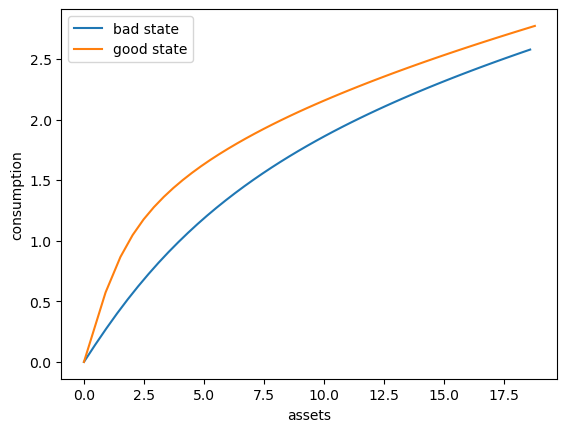

In [15]:
fig, ax = plt.subplots()
ax.plot(ae_vals[:, 0], c_vals[:, 0], label='bad state')
ax.plot(ae_vals[:, 1], c_vals[:, 1], label='good state')
ax.set(xlabel='assets', ylabel='consumption')
ax.legend()
plt.show()

### Dynamics

To begin to understand the long run asset levels held by households under the default parameters, let's look at the
45 degree diagram showing the law of motion for assets under the optimal consumption policy.

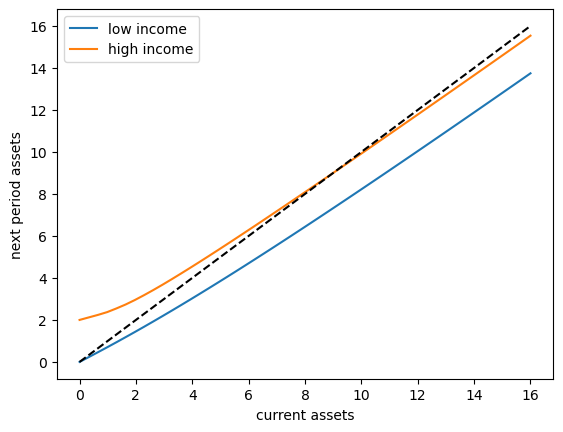

In [16]:
fig, ax = plt.subplots()

for k, label in zip((0, 1), ('low income', 'high income')):
    # Interpolate consumption policy on the savings grid
    c_on_grid = jnp.interp(s, ae_vals[:, k], c_vals[:, k])
    ax.plot(s, R * (s - c_on_grid) + y(z_grid[k]) , label=label)

ax.plot(s, s, 'k--')
ax.set(xlabel='current assets', ylabel='next period assets')

ax.legend()
plt.show()

The unbroken lines show the update function for assets at each $z$, which is

$$
    a \mapsto R (a - \sigma^*(a, z)) + y(z')
$$

where we plot this for a particular realization $z' = z$.

The dashed line is the 45 degree line.

The figure suggests that the dynamics will be stable --- assets do not diverge
even in the highest state.

In fact there is a unique stationary distribution of assets that we can calculate by simulation -- we examine this below.

* Can be proved via theorem 2 of {cite}`HopenhaynPrescott1992`.
* It represents the long run dispersion of assets across households when households have idiosyncratic shocks.



### A Sanity Check

One way to check our results is to

* set labor income to zero in each state and
* set the gross interest rate $R$ to unity.

In this case, our income fluctuation problem is just a CRRA cake eating problem.

Then the value function and optimal consumption policy are given by

In [17]:
def c_star(x, β, γ):
    return (1 - β ** (1/γ)) * x


def v_star(x, β, γ):
    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

Let's see if we match up:

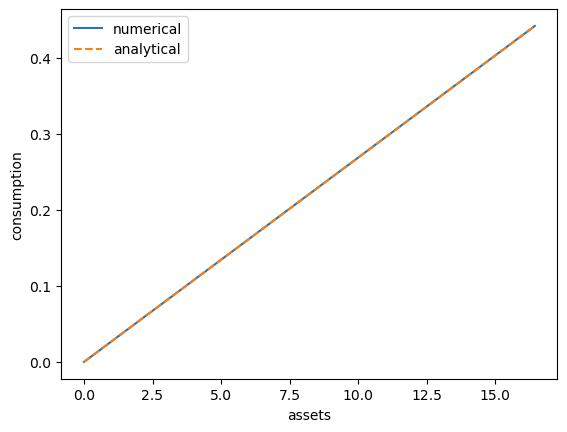

In [18]:
ifp_cake_eating = create_ifp(r=0.0, z_grid=(-jnp.inf, -jnp.inf))
R, β, γ, Π, z_grid, s = ifp_cake_eating
c_vals_init = s[:, None] * jnp.ones(len(z_grid))
c_vals, ae_vals = solve_model(ifp_cake_eating, c_vals_init)

fig, ax = plt.subplots()
ax.plot(ae_vals[:, 0], c_vals[:, 0], label='numerical')
ax.plot(ae_vals[:, 0],
        c_star(ae_vals[:, 0], ifp_cake_eating.β, ifp_cake_eating.γ),
        '--', label='analytical')
ax.set(xlabel='assets', ylabel='consumption')
ax.legend()
plt.show()

This looks pretty good.


## Exercises

```{exercise-start}
:label: ifp_ex1
```

Let's consider how the interest rate affects consumption.

* Step `r` through `np.linspace(0, 0.016, 4)`.
* Other than `r`, hold all parameters at their default values.
* Plot consumption against assets for income shock fixed at the smallest value.

Your figure should show that, for this model, higher interest rates 
suppress consumption (because they encourage more savings).

```{exercise-end}
```

```{solution-start} ifp_ex1
:class: dropdown
```

Here's one solution:

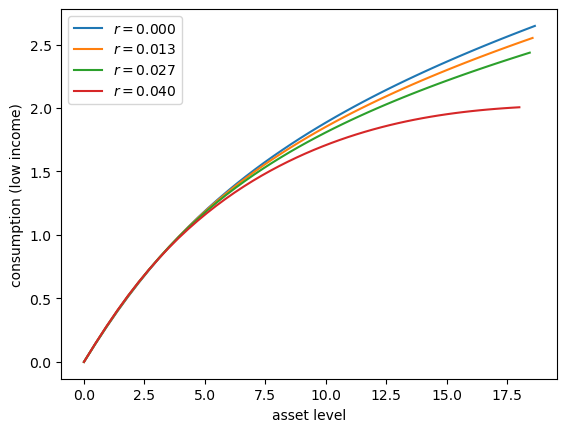

In [19]:
# With β=0.96, we need R*β < 1, so r < 0.0416
r_vals = np.linspace(0, 0.04, 4)

fig, ax = plt.subplots()
for r_val in r_vals:
    ifp = create_ifp(r=r_val)
    R, β, γ, Π, z_grid, s = ifp
    c_vals_init = s[:, None] * jnp.ones(len(z_grid))
    c_vals, ae_vals = solve_model(ifp, c_vals_init)
    ax.plot(ae_vals[:, 0], c_vals[:, 0], label=f'$r = {r_val:.3f}$')

ax.set(xlabel='asset level', ylabel='consumption (low income)')
ax.legend()
plt.show()

```{solution-end}
```


```{exercise-start}
:label: ifp_ex2
```

Let's approximate the stationary distribution by simulation.

Run a large number of households forward for $T$ periods and then histogram the
cross-sectional distribution of assets.

Set `num_households=50_000, T=500`.

```{exercise-end}
```

```{solution-start} ifp_ex2
:class: dropdown
```

First we write a function to simulate many households in parallel using JAX.

In [20]:
def compute_asset_stationary(
        ifp, c_vals, ae_vals, num_households=50_000, T=500, seed=1234
    ):
    """
    Simulates num_households households for T periods to approximate
    the stationary distribution of assets.

    By ergodicity, simulating many households for moderate time is equivalent to
    simulating one household for very long time, but parallelizes better.

    ifp is an instance of IFP
    c_vals, ae_vals are the consumption policy and endogenous grid from
    solve_model
    """
    R, β, γ, Π, z_grid, s = ifp
    n_z = len(z_grid)

    # Create interpolation function for consumption policy
    # Interpolate on the endogenous grid
    σ = lambda a, z_idx: jnp.interp(a, ae_vals[:, z_idx], c_vals[:, z_idx])

    # Simulate one household forward
    def simulate_one_household(key):

        # Random initial state (a, z)
        key1, key2, key3 = jax.random.split(key, 3)
        z_idx = jax.random.choice(key1, n_z)
        # Start with random assets drawn from [0, savings_grid_max/2]
        a = jax.random.uniform(key3, minval=0.0, maxval=s[-1]/2)

        # Simulate forward T periods
        def step(state, key_t):
            a, z_idx = state
            # Consume based on current state
            c = σ(a, z_idx)
            # Draw next shock
            z_next_idx = jax.random.choice(key_t, n_z, p=Π[z_idx])
            # Update assets: a' = R*(a - c) + Y'
            z_next = z_grid[z_next_idx]
            a_next = R * (a - c) + y(z_next)
            return (a_next, z_next_idx), None

        keys = jax.random.split(key2, T)
        initial_state = a, z_idx
        final_state, _ = jax.lax.scan(step, initial_state, keys)
        a_final, _ = final_state
        return a_final

    # Vectorize over many households
    key = jax.random.PRNGKey(seed)
    keys = jax.random.split(key, num_households)
    sim_all_households = jax.vmap(simulate_one_household)
    assets = sim_all_households(keys)

    return np.array(assets)

Now we call the function, generate the asset distribution and histogram it:

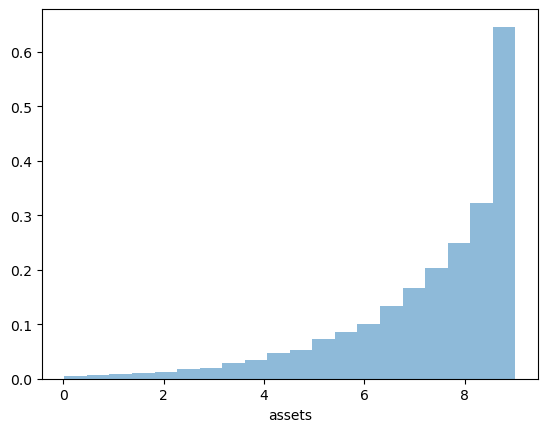

In [21]:
ifp = create_ifp()
R, β, γ, Π, z_grid, s = ifp
c_vals_init = s[:, None] * jnp.ones(len(z_grid))
c_vals, ae_vals = solve_model(ifp, c_vals_init)
assets = compute_asset_stationary(ifp, c_vals, ae_vals)

fig, ax = plt.subplots()
ax.hist(assets, bins=20, alpha=0.5, density=True)
ax.set(xlabel='assets')
plt.show()

The shape of the asset distribution is unrealistic.

Here it is left skewed when in reality it has a long right tail.

In a {doc}`subsequent lecture <ifp_advanced>` we will rectify this by adding
more realistic features to the model.

```{solution-end}
```



```{exercise-start}
:label: ifp_ex3
```

Following on from exercises 1 and 2, let's look at how savings and aggregate
asset holdings vary with the interest rate

```{note}
{cite}`Ljungqvist2012` section 18.6 can be consulted for more background on the topic treated in this exercise.
```
For a given parameterization of the model, the mean of the stationary
distribution of assets can be interpreted as aggregate capital in an economy
with a unit mass of *ex-ante* identical households facing idiosyncratic
shocks.

Your task is to investigate how this measure of aggregate capital varies with
the interest rate.

Following tradition, put the price (i.e., interest rate) on the vertical axis.

On the horizontal axis put aggregate capital, computed as the mean of the
stationary distribution given the interest rate.

Use

In [22]:
M = 12
r_vals = np.linspace(0, 0.015, M)

```{exercise-end}
```

```{solution-start} ifp_ex3
:class: dropdown
```

Here's one solution

Solving model at r = 0.0
  Mean assets: 6.5712
Solving model at r = 0.0013636363636363635
  Mean assets: 6.6597
Solving model at r = 0.002727272727272727
  Mean assets: 6.7521
Solving model at r = 0.00409090909090909
  Mean assets: 6.8489
Solving model at r = 0.005454545454545454
  Mean assets: 6.9512
Solving model at r = 0.006818181818181818
  Mean assets: 7.0584
Solving model at r = 0.00818181818181818
  Mean assets: 7.1721
Solving model at r = 0.009545454545454544
  Mean assets: 7.2919
Solving model at r = 0.010909090909090908
  Mean assets: 7.4194
Solving model at r = 0.012272727272727272
  Mean assets: 7.5545
Solving model at r = 0.013636363636363636
  Mean assets: 7.6987
Solving model at r = 0.015
  Mean assets: 7.8529


  Mean assets: 6.5712
Solving model at r = 0.0013636363636363635


  Mean assets: 6.6597
Solving model at r = 0.002727272727272727


  Mean assets: 6.7521
Solving model at r = 0.00409090909090909


  Mean assets: 6.8489
Solving model at r = 0.005454545454545454


  Mean assets: 6.9512
Solving model at r = 0.006818181818181818


  Mean assets: 7.0584
Solving model at r = 0.00818181818181818


  Mean assets: 7.1721
Solving model at r = 0.009545454545454544


  Mean assets: 7.2919
Solving model at r = 0.010909090909090908


  Mean assets: 7.4194
Solving model at r = 0.012272727272727272


  Mean assets: 7.5545
Solving model at r = 0.013636363636363636


  Mean assets: 7.6987
Solving model at r = 0.015


  Mean assets: 7.8529


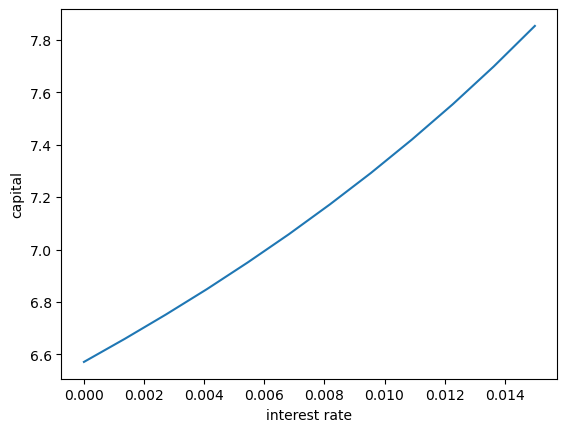

In [23]:
fig, ax = plt.subplots()

asset_mean = []
for r in r_vals:
    print(f'Solving model at r = {r}')
    ifp = create_ifp(r=r)
    R, β, γ, Π, z_grid, s = ifp
    c_vals_init = s[:, None] * jnp.ones(len(z_grid))
    c_vals, ae_vals = solve_model(ifp, c_vals_init)
    assets = compute_asset_stationary(ifp, c_vals, ae_vals, num_households=10_000, T=500)
    mean = np.mean(assets)
    asset_mean.append(mean)
    print(f'  Mean assets: {mean:.4f}')
ax.plot(r_vals, asset_mean)

ax.set(xlabel='interest rate', ylabel='capital')

plt.show()

As expected, aggregate savings increases with the interest rate.

```{solution-end}
```